In [1]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset
import pickle 
from sklearn.cluster import KMeans

from utilities import *
import os

from pyvox.models import Vox, Color
from pyvox.writer import VoxWriter


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda'


In [2]:
focal, all_c2w, all_gt = get_data("../lego")

LOAD DATA ../lego/train


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


In [4]:
def reduce_data(all_c2w, all_gt, focal, red_fac, N_points):
    H,W = all_gt[0].shape[:2]
    red_ims = [gt[::red_fac,::red_fac,:] for gt in all_gt]
    red_rays_or_dir = [get_rays_np(H,W, focal, c2w) for c2w in all_c2w]
    rays = [e[0][::red_fac,::red_fac,:, None] + np.arange(N_points)/10*e[1][::red_fac, ::red_fac,:, None] for e in red_rays_or_dir]
    
    return red_ims, rays


def laplacian3d(arr):
    dx = (arr - torch.roll(arr, 1, 0))**2
    dy = (arr - torch.roll(arr, 1, 1))**2
    dz = (arr - torch.roll(arr, 1, 2))**2
    return torch.sqrt(dx+dy+dz)



In [10]:
class VoxelGrid():
    def __init__(self, size=128, bound_w=1):
        self.size = size
        self.bound_w = bound_w
        self.colors =  Variable(torch.rand((size*size*size,3)).to(device), requires_grad=True)
        self.opacities =  Variable(torch.rand((size*size*size)).to(device), requires_grad=True)
        
        x = np.linspace(-bound_w,bound_w,size)
        y = np.linspace(-bound_w,bound_w,size)
        z = np.linspace(-bound_w,bound_w,size)
        self.meshgrid = np.meshgrid(x,y,z)

    def in_bounds_indices(self, p):
        ''' input: Nx3 array
            output: index of valid arrays'''
        in_x = (p[...,0]>=0)*(p[...,0]<self.size)
        in_y = (p[...,1]>=0)*(p[...,1]<self.size)
        in_z = (p[...,2]>=0)*(p[...,2]<self.size)
        return in_x*in_y*in_z
    
    def descartes_to_indices(self, p):
        ''' input: Nx3 array, 3D points
            out: Nx3 array, 3D indices in [0, size['''
        q = torch.zeros_like(p)
        q[..., 0] = (p[...,0]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        q[..., 1] = (p[...,1]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        q[..., 2] = (p[...,2]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        return q

    def flatten_3d_indices(self, inds_3d):
        ''' input: Nx3 array of indices
            out: N array of flatten indices'''
        return inds_3d[...,0] + self.size*inds_3d[...,1] + self.size*self.size*inds_3d[...,2]

    def render_rays(self, p):
        with torch.no_grad():
            # extract valid indices
            inds_3d = self.descartes_to_indices(p)
            in_bounds = self.in_bounds_indices(torch.floor(inds_3d).to(device))
            # meshgrid coordinates
            mesh_coords = self.flatten_3d_indices(inds_3d.long())
            mesh_coords[torch.logical_not(in_bounds)] = 0

        colors = self.colors[mesh_coords]
        opacities = self.opacities[mesh_coords]*in_bounds.float()
        cumsum_opacities = torch.cumsum(opacities, 1)
        
        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        return (colors*transp_term[..., None]).sum(1)

    def update_grads(self, lr):
        self.colors.data -= lr * self.colors.grad.data        
        self.opacities.data -= lr * self.opacities.grad.data
       
        self.opacities.data = torch.clamp(self.opacities.data, 0)
        self.colors.data = torch.clamp(self.colors.data, 0,1)

        self.colors.grad.data.zero_()
        self.opacities.grad.data.zero_()
        
    def copy(self):
        CopyGrid = VoxelGrid(self.size,self.bound_w)
        CopyGrid.colors = torch.clone(self.colors)
        CopyGrid.opacities = torch.clone(self.opacities)
        return CopyGrid
    
    def save(self, filename="VoxelGrid.obj"):
        filehandler = open("saved_grids/" + filename, 'wb') 
        pickle.dump(self, filehandler)
        
    def load(self, filename="VoxelGrid.obj"):
        filehandler = open("saved_grids/" + filename, 'rb') 
        self.__dict__.update(pickle.load(filehandler).__dict__)
    
    def treshold_opacity(self, r):
        voxel_opacity = (1-torch.exp(-self.opacities))
        with torch.no_grad():
            self.opacities[voxel_opacity<r]=0
            
    def make_palette(self, n=50):
        kmeans = KMeans(n_clusters=n).fit(self.colors.cpu().detach().numpy())
        colors = np.ones((n,4))
        colors[:,:3]=kmeans.cluster_centers_
        return kmeans.labels_, np.minimum(255, np.maximum(0, 255*colors)).astype(int)
        

    def save_magica_vox(self, tresh=0, filename="test.vox"):
        out_voxels = np.zeros((self.size, self.size, self.size), dtype='B')
        palette = []
        #TODO: add unfold_array
        in_palette, colors = self.make_palette(50)
        for i in tqdm(range(self.size)):
            for j in range(self.size):
                for k in range(self.size):
                    ind = self.flatten_3d_indices(np.array([k,j,i]))
                    voxel_opacity = (1-torch.exp(-self.opacities[ind,None]))
                    if voxel_opacity>tresh:
                        out_voxels[i,j,k] = in_palette[ind]
        vox = Vox.from_dense(out_voxels)
        vox.palette = colors
        VoxWriter("saved_grids/" + filename, vox).write()       
        
    def unfold_arrays(self):
        unfolded_colors = self.colors.view((self.size, self.size, self.size, 3)).transpose(2,0)
        unfolded_opacities =  self.opacities.view((self.size, self.size, self.size)).transpose(2,0)
        return unfolded_colors, unfolded_opacities
    
    def total_variation(self):
        unfolded_colors, unfolded_opacities = self.unfold_arrays()
        lap_color = laplacian3d(unfolded_colors).sum()
        lap_opacities = laplacian3d(unfolded_opacities).sum()
        return (lap_color/3 + lap_opacities)/(2*self.size**3)


In [8]:
N_points = 100

red = 8
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red, N_points)
im_w = target_ims[0].shape[0]
print(im_w)

red = 4
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red, N_points)
disp_im_w = disp_ims[0].shape[0]
print(disp_im_w)

100
200


In [9]:
class RayDataset(Dataset):
    def __init__(self, target_ims, rays):
        self.im_w = target_ims[0].shape[0]

        self.tensor_rays = []
        self.tensor_target_pixels = []
        
        for image_ind in tqdm(range(im_w)):
            for i in range(im_w):
                for j in range(im_w):
                    self.tensor_rays.append(torch.tensor(rays[image_ind][i,j], dtype=torch.float32).to(device).T)
                    self.tensor_target_pixels.append(torch.tensor(target_ims[image_ind][i,j], dtype=torch.float32).to(device))

    def __getitem__(self, index):
        return self.tensor_rays[index], self.tensor_target_pixels[index]
    def __len__(self):
        return len(self.tensor_rays)

D = RayDataset(target_ims, rays)

100%|█████████████████████████████████████████| 100/100 [00:46<00:00,  2.17it/s]


In [13]:
losses=[]

train_loader = torch.utils.data.DataLoader(D, batch_size=10000, shuffle=True)
len(train_loader)


100

In [14]:
VG = VoxelGrid(40, 1)
VG.load('0.05.obj')

In [15]:
def train(epoch):
    losses=[]
    for batch_idx, (rays, pixels) in enumerate(train_loader):
        pix_estims = VG.render_rays(rays)
        loss = ((pix_estims-pixels)**2).sum()/rays.shape[0]
        loss.backward()
        losses.append(loss.item())
        VG.update_grads(500)
        if batch_idx%1==0:
            print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx,
                        len(train_loader),
                        100.0 * batch_idx / len(train_loader),
                        loss.data.item(),
                    )
                )
    return losses

for epoch in tqdm(range(1)):
    losses += train(epoch)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Train Epoch: 0 [0/100 (0%)]	Loss: 0.036500
Train Epoch: 0 [1/100 (1%)]	Loss: 0.068485
Train Epoch: 0 [2/100 (2%)]	Loss: 0.069162
Train Epoch: 0 [3/100 (3%)]	Loss: 0.066539
Train Epoch: 0 [4/100 (4%)]	Loss: 0.063543
Train Epoch: 0 [5/100 (5%)]	Loss: 0.066560
Train Epoch: 0 [6/100 (6%)]	Loss: 0.067694
Train Epoch: 0 [7/100 (7%)]	Loss: 0.063674
Train Epoch: 0 [8/100 (8%)]	Loss: 0.065054
Train Epoch: 0 [9/100 (9%)]	Loss: 0.063704
Train Epoch: 0 [10/100 (10%)]	Loss: 0.065794
Train Epoch: 0 [11/100 (11%)]	Loss: 0.061340
Train Epoch: 0 [12/100 (12%)]	Loss: 0.060543
Train Epoch: 0 [13/100 (13%)]	Loss: 0.062152
Train Epoch: 0 [14/100 (14%)]	Loss: 0.061580
Train Epoch: 0 [15/100 (15%)]	Loss: 0.065978
Train Epoch: 0 [16/100 (16%)]	Loss: 0.061749
Train Epoch: 0 [17/100 (17%)]	Loss: 0.062620
Train Epoch: 0 [18/100 (18%)]	Loss: 0.060104
Train Epoch: 0 [19/100 (19%)]	Loss: 0.061888
Train Epoch: 0 [20/100 (20%)]	Loss: 0.061238
Train Epoch: 0 [21/100 (21%)]	Loss: 0.063450
Train Epoch: 0 [22/100 (22%)]	

100%|████████████████████████████████████████████| 1/1 [02:27<00:00, 147.02s/it]

Train Epoch: 0 [99/100 (99%)]	Loss: 0.055327


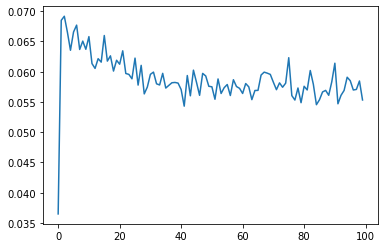

In [16]:
plt.plot(losses)

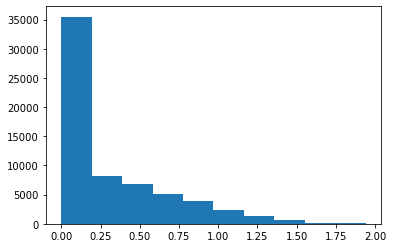

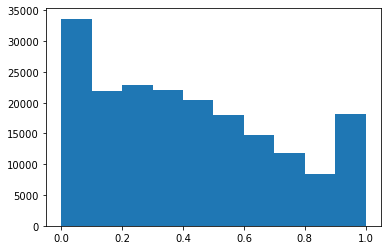

In [20]:
plt.hist(VG.opacities.tolist())
plt.show()
plt.hist(VG.colors.flatten().tolist())
plt.show()




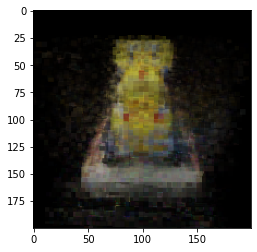

In [21]:
image_ind=0
tensor_rays_img = torch.tensor(disp_rays[image_ind], dtype=torch.float32).to(device).permute((0,1,3,2)).view((disp_im_w*disp_im_w,N_points,3))

new_im = VG.render_rays(tensor_rays_img).view((disp_im_w,disp_im_w,3)).cpu().detach().numpy()

plt.imshow(new_im)

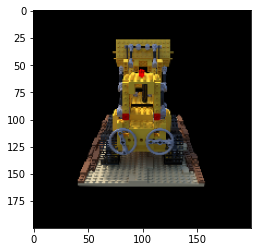

In [24]:
plt.imshow(disp_ims[image_ind])

In [23]:
#VG.save_magica_vox(0.4)

# TEST

In [27]:
VG2 = VoxelGrid()
VG2.load('0.05_clamp.obj')

In [28]:
test_focal, test_c2w, test_gt = get_data("../lego", "test")

LOAD DATA ../lego/test


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 51.10it/s]


In [ ]:
red = 2
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red, N_points)
disp_im_w = disp_ims[0].shape[0]

In [ ]:
image_ind=6
tensor_rays_img = torch.tensor(disp_rays_test[image_ind], dtype=torch.float32).to(device).permute((0,1,3,2)).view((disp_im_w*disp_im_w,N_points,3))

new_im = VG2.render_rays(tensor_rays_img).view((disp_im_w,disp_im_w,3)).cpu().detach().numpy()

plt.imshow(new_im)
plt.show()
plt.imshow(disp_ims_test[image_ind])